# Problem

$\blacktriangleright$ Here we have incompressible Navier-Stokes equation, written in div-grad formulation i.e. in terms of the simmetric strain-rate, and we will comparare some of the two fundamental optimal preconditioners the _block diagonal_ and _block triangular_ ones and finally the classical _ILU preconditioner_
</br>

$1. $ problem statement onto the $\Omega$ rectangular domain

$$
\begin{equation}
    \begin{cases}
        -\text{div}(2\nu D(u))+(u\cdot \nabla)u +\nabla p=0 &\quad in\thinspace \Omega\\
        \text{div}u=0  &\quad in\thinspace \Omega\\
        u=4y(1-y) &\quad on\thinspace \partial\Gamma_{in}\\
        -p\hat{n}+2\nu D(u)\hat{n}=0.1  &\quad on\thinspace \partial\Gamma_{out_1}\\
        -p\hat{n} +2\nu D(u)\hat{n}=0 &\quad on\thinspace \partial\Gamma_{out_2}\\
        u=0 &\quad on\thinspace \partial\Omega/\Gamma_{in}\cup\Gamma_{out_1}\cup\Gamma_{out_2}
    \end{cases}
\end{equation}
$$
The intial condition for this steady non linear problem is retrieved by solving its associated Stokes problem (in LU factorization and MUMPS as backend). Rewriting in matrix-vector form
</br>
\begin{align}
\overbrace{AU_k+N(U_{k-1})U_{k}}^{CU_k}+B^TP_k=0\\
BU_k=0
\end{align}
that is
\begin{align}
\underbrace{\begin{bmatrix}
A + N(U_{k-1}) & B^T\\
B & 0
\end{bmatrix}}_{\Sigma_{1}}
\begin{bmatrix}
U_{k}\\
P_{k}
\end{bmatrix}
=
\begin{bmatrix}
0\\
0
\end{bmatrix}
\end{align}


$2. $ now considering the Newton method for the non-linear term, the weak formulation of the problem is
$$
\begin{align*}
    2\nu\int_{\Omega}D(u_k):D(v)d\Omega -2\nu\int_{\Gamma_N}D(u_k)\hat{n}vd\Gamma_N + \int_{\Omega}(u_{k-1}\cdot\nabla)u_kvd\Omega +\int_{\Omega}(u_k\cdot\nabla)u_{k-1}vd\Omega\\
    +\int_{\Gamma_N}p_k\hat{n}vd\Gamma_N-\int_{\Omega}p_k\text{div}(v)d\Omega +\int_{\Omega}q\text{div}(u_k)d\Omega=\int_{\Omega}(u_{k-1}\cdot\nabla)u_{k-1}d\Omega
\end{align*}$$
introducing the natural neumann boundary conditions declared before, the weak formulation to be implemented becomes
$$
\begin{align*}
    2\nu\int_{\Omega}D(u_k):D(v)d\Omega + \int_{\Omega}(u_{k-1}\cdot\nabla)u_kvd\Omega +\int_{\Omega}(u_k\cdot\nabla)u_{k-1}vd\Omega\\
    -\int_{\Omega}p_k\text{div}(v)d\Omega +\int_{\Omega}q\text{div}(u_k)d\Omega=\int_{\Gamma_N}\gamma vd\Gamma_N+\int_{\Omega}(u_{k-1}\cdot\nabla)u_{k-1}d\Omega
\end{align*}$$

</br>
$3. $ The functional spaces involved are</br>
Test space:
$$\begin{equation*}
    V_0=\{v\in [H^1(\Omega)]^d_{\Gamma_{in}\cup \partial\Omega/\Gamma_{in}\cup\Gamma_{out_1}\cup\Gamma_{out_2}}:\thinspace v\vert_{\Gamma_D}=0\}
\end{equation*}$$
Trial space:
$$\begin{equation*}
    V_D=\{v\in [H^1(\Omega)]^d:v\vert_{\Gamma_{in}}=4y(1-y),\thinspace v\vert_{\partial\Omega/\Gamma_{in}\cup\Gamma_{out_1}\cup\Gamma_{out_2}}=0\}
\end{equation*}$$

</br>
$4. $ The optimal preconditiones to implement are the block diagonal $\mathcal{P}_1$ and the block triangular $\mathcal{P}_2$ by means of $\verb|PETSc|$
$$
\begin{equation}
\mathcal{P}_1=\begin{bmatrix}
    C & 0\\
    0 & \frac{1}{\nu}M_p
\end{bmatrix},\quad
\mathcal{P}_2=\begin{bmatrix}
    C & 0\\
    -B& \frac{1}{\nu}M_p
\end{bmatrix}
\end{equation}$$
The $\verb|ILU|$ preconditioner can be retrieved through $\verb|PETSc|$. Here $M_p$ is the Pressure Mass Matrix (PMM) an optimal preconditioner for the $\textit{Schur}$ complement, it is derived from the bounding of the Rayleigh quotient related to the Schur problem. The PMM is defined in this case as
\begin{equation}
M_p=\int_{\Omega}u_kvd\Omega
\end{equation}

$5.$ Algorithms </br>
Here the whole NS matrix $\Sigma_1$ is preconditioned and then solved using an iterative method, the GMRES. What we can expect is that for each i-iteration other k-subiterations of the GMRES are done (solution of the NS matrix and of the preconditioners). The comparison arises between the block diagonal (BD) preconditioner and the block triangular (BT) preconditioner, since the BT one better resembles the original NS matrix by construction, thus $\mathcal{P}_2$ will be more heavy to compute because there are three blocks to be solved, but the number of GMRES iterations dops by a factor of two wtr the BD one! in turn since they are optimal preconditioners increasing the dimension of the problem i.e. more mesh elements the condition number $\mathcal{K}(C)$ of the NS matrix doesnt increase as it normally happens by a factor of $h^{-2}$, therefore the problem will definetly larger but without the obiquitous issue of the condition number that slows down the inversion of the matrix. Unfortunately $\verb|ILU|$ preconditioner is not an optimal preconditioner for the NS equation, it works very well for diffusion-problems but not when a second field (pressure) is considered inside the actual PDE

In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

from firedrake.petsc import PETSc

In [ ]:
# Get current path: all relative paths that you may use for input/output start from here.
#
# - Colab:  The default path is /content, and your GDrive folder is accessible (if mounted) at /content/drive/MyDrive
#
# - local:  If running on your local machine, current_path is the position WHERE YOU LAUNCHED THE NOTEBOOK KERNEL BY 'jupyter notebook'
#           and NOT the directory in which this ipynb file is saved.
#           If you want to modify your current path, go to the terminal, stop the kernel (ctrl-C + press y), then move to the desired path by
#           cd my/desired/path/starting/from/here
#           and then launch 'jupyter notebook'.
import os
current_path = os.getcwd()
print(current_path)

/content


---
---
## Solve nonlinear, steady Navier-Stokes problem.

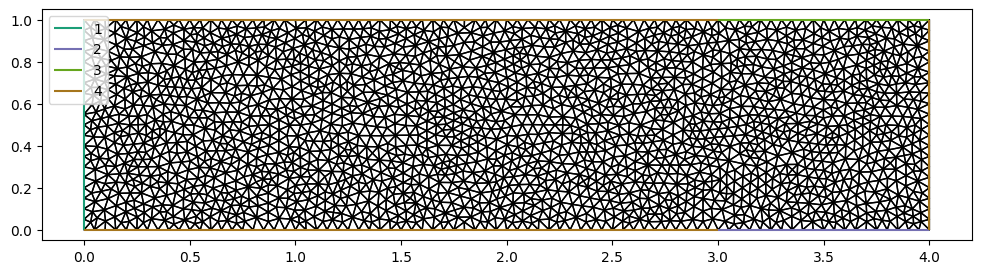

In [ ]:
# Import mesh: set the path correctly!
mesh = Mesh('/content/drive/MyDrive/meshes/...')
fig, ax = plt.subplots(figsize=(12,3))
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [ ]:
# Function spaces, data and boundary conditions
V=VectorFunctionSpace(mesh, 'P',2)
Q=FunctionSpace(mesh,'P',1)
W=MixedFunctionSpace([V,Q])
x = SpatialCoordinate(mesh)
u_in = as_vector(( 4*x[1]*(1-x[1]) , 0))
gN=Constant((0,0.1))
nu=0.05
no_slip_velocity=Constant((0,0))
no_slip_bc=DirichletBC(W.sub(0),no_slip_velocity,4)
inlet_bc=DirichletBC(W.sub(0),u_in,1)
bcs = ( no_slip_bc,inlet_bc )

### Variational problems

In [ ]:
# u:  trial velocity
# v:  test velocity
# p:  trial pressure
# q:  test pressure
def initialization_problem_forms(u, v, p, q, nu,gN):
    # Stokes initialization
    a_stokes = 2*nu*inner(sym(grad(u)),sym(grad(v)))*dx \
               +p*div(v)*dx \
               +q*div(u)*dx

    L_stokes = inner(gN,v)*ds(2)
    return a_stokes, L_stokes

# u:  trial velocity
# v:  test velocity
# p:  trial pressure
# q:  test pressure
def newton_iteration_forms(u, v, p, q, u_old,nu,gN):
    a = 2*nu*inner(sym(grad(u)),sym(grad(v)))*dx\
        +inner(dot(grad(u),u_old),v)*dx\
        +inner(dot(grad(u_old),u),v)*dx\
        -p*div(v)*dx\
        +q*div(u)*dx

    L = inner(gN,v)*ds(2)\
        +inner(dot(grad(u_old),u_old),v)*dx

    return a, L


### Initialization.

init: GMRES iter =  1


/usr/local/lib/python3.11/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


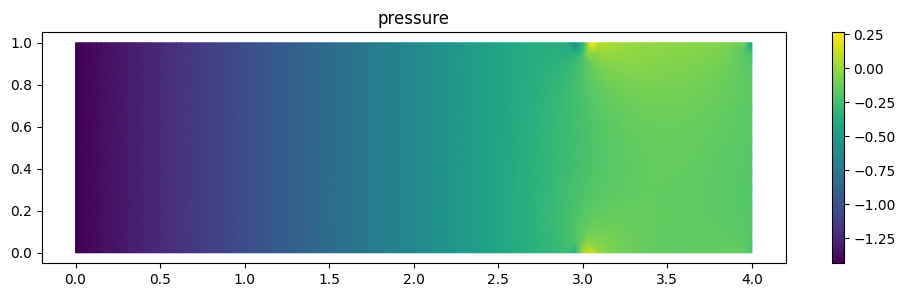

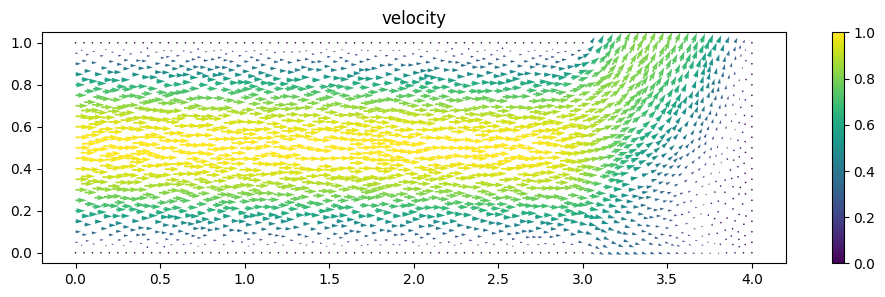

In [ ]:
u, p = TrialFunctions( W )
v, q = TestFunctions( W )

# Initialization solver
wh_init = Function( W )
a_init, L_init = initialization_problem_forms( u, v, p, q, nu,gN )
init_problem = LinearVariationalProblem(a_init, L_init, wh_init, bcs)
param_init = {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}

solver_init =  LinearVariationalSolver(init_problem, solver_parameters=param_init)

# Actual initialization
solver_init.solve()
uh, ph = wh_init.subfunctions

print("init: GMRES iter = ", solver_init.snes.ksp.getIterationNumber())

# Plot of initial guess (Stokes solution)
fig, ax = plt.subplots(figsize=(12,3))
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots(figsize=(12,3))
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')

# vtk output for Paraview
outfileU = File("/content/drive/MyDrive/velocity.pvd")
outfileP = File("/content/drive/MyDrive/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

### Settings of the ***linear*** solver for each nonlinear iteration.

In [ ]:
# Nonlinear solver
u_old = Function(V)
u_old.assign(uh)
p_old = Function(Q)
p_old.assign(ph)
wh = Function(W)

pc_form = 2*nu*inner(sym(grad(u)),sym(grad(v)))*dx + p * q * dx     #block diagonal preconditioner
pc_form_1 = inner(grad(u), grad(v)) * dx + p * q * dx + div(u)*q*dx #block triangular preconditioner

# SOLVER PARAMETERS
param = {'ksp_type': 'gmres',   #GMRES per risolvere la matrice sigma, "lu" per risolvere i blocchi del preconditioner P, cioè P0,P1
              'ksp_rtol': 1.e-8, 'ksp_max_it': 2000,
              "pc_type": "fieldsplit",                                              # use block structure of monolithic matrix
              "pc_fieldsplit_type": "multiplicative",    # (multiplicative/additive)                # use a block diagonal preconditioner (taken from pc_form)
              "fieldsplit_0_ksp_type": "preonly", "fieldsplit_0_pc_type": "lu",     # block P0 is "inverted" by LU factorization
              "fieldsplit_1_ksp_type": "preonly", "fieldsplit_1_pc_type": "lu"}     # "inverse" of block P1 is approximated by ILU factorization



"param = {'ksp_type': 'gmres', 'ksp_gmres_restart': 2000,\n          ...,\n          'ksp_max_it': 2000, ...}"

In [ ]:
a,L=newton_iteration_forms(u, v, p, q, u_old,nu,gN)

### Iterative algorithm for the solution of the nonlinear problem

In [ ]:
maxit = 100
it = 0
tol = 1e-3
relative_increment = tol+1     # >tol in order to enter the loop at the beginning

while it <= maxit and relative_increment > tol:

    it += 1

    a,L=newton_iteration_forms(u, v, p, q, u_old,nu,gN)

    problem = LinearVariationalProblem( a,L,wh,bcs=bcs,aP=pc_form_1 )

    solver =  LinearVariationalSolver(problem, solver_parameters=param)

    solver.solve()
    uh, ph = wh.subfunctions

    relative_increment = errornorm(uh,u_old,'H1')/norm(u_old,'H1')+errornorm(ph,p_old,'L2')/norm(p_old,'L2')


    print("Iteration = ", it, " Rel.incr. = ", relative_increment, 'iter =', solver.snes.ksp.getIterationNumber())
    uh.rename("Velocity")
    ph.rename("Pressure")
    outfileU.write(uh)
    outfileP.write(ph)

    u_old.assign(uh)
    p_old.assign(ph) # update the old solution

if it <= maxit:
    print('Nonlinear solver converged in', it, 'iterations.')
else:
    print('Nonlinear solver did NOT converge!\nRel.incr. = ', relative_increment, 'after', it, 'iterations.')

Iteration =  1  Rel.incr. =  2.0505491687220894 iter = 202
Iteration =  2  Rel.incr. =  0.06800504898601012 iter = 265
Iteration =  3  Rel.incr. =  0.0022948916175995144 iter = 257
Iteration =  4  Rel.incr. =  5.482168865470138e-07 iter = 254
Nonlinear solver converged in 4 iterations.


Text(0.5, 1.0, 'velocity')

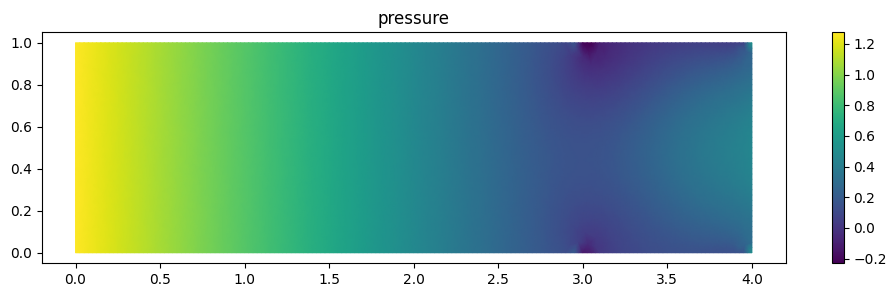

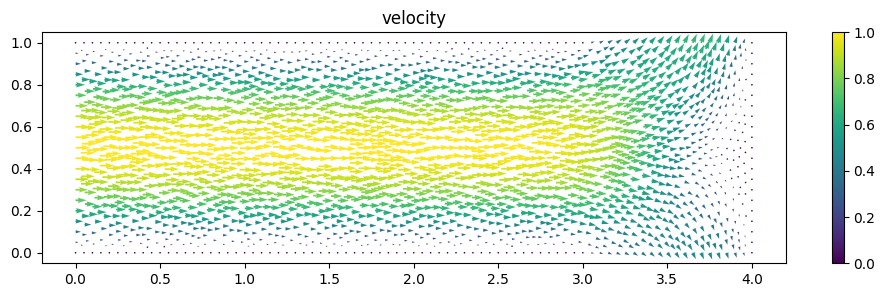

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots(figsize=(12,3))
col = quiver(uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')

In [ ]:
# Compute flowrate
normal=FacetNormal(mesh)
flow_rate1=assemble(dot(uh,normal)*ds(3))
flow_rate2=assemble(dot(uh,normal)*ds(2))
print('Flowrate Gamma_out1', flow_rate1 )
print('Flowrate Gamma_out2', flow_rate2 )

Flowrate Gamma_out1 0.394134905542726
Flowrate Gamma_out2 0.2725317611239651
